In [4]:
# Basic Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import string

# Webscrapping Imports
from bs4 import BeautifulSoup       
import regex as re

# NLP Imports
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud, ImageColorGenerator
import nltk

# Modelling Imports
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

#Stylistic Choice:
plt.style.use('bmh')
sns.set_palette("RdBu_r")

In [5]:
#loading in data sets
onion = pd.read_csv('../data/theonion.csv')
news = pd.read_csv('../data/news.csv')

In [6]:
#quick look at the loaded datasets
onion.info

<bound method DataFrame.info of       created_utc subreddit                                              title
0      1635090051  TheOnion  Smithsonian Acquires Arms Of Kermit The Frog P...
1      1634958726  TheOnion  Less Popular Friend Only Included In Suicide P...
2      1634940672  TheOnion  Crypto-Averse Man Would Prefer Investing In Tr...
3      1634910709  TheOnion  God Loses Pouch Filled With Crystals That Give...
4      1634872463  TheOnion  Retired NFL Player Touts Sports Betting App As...
...           ...       ...                                                ...
2013   1580708304  TheOnion  The Onion is made a podcast called "The Topica...
2014   1580691176  TheOnion  ‘I’m Just Here For The Commercials,’ Jokes Man...
2015   1580669936  TheOnion     My god how much Budget did they have for this?
2016   1580662117  TheOnion      Snacks Distract Lawmakers From Horrors of War
2017   1580589888  TheOnion  Onion Talks: Hypothetically It Would Be Okay T...

[2018 rows x 3 colu

In [7]:
#quick look at the loaded datasets
news.info

<bound method DataFrame.info of       created_utc subreddit                                              title
0      1635118883      news  Supporters of unvaccinated NBA star Kyrie Irvi...
1      1635118006      news  Body of missing 26-year-old Texas man found in...
2      1635116237      news  Two SF Prosecutors Quit &amp; Join Effort to O...
3      1635115094      news  James Michael Tyler, who played Gunther in 'Fr...
4      1635114451      news  Plane from NY to LA makes emergency landing in...
...           ...       ...                                                ...
2006   1633613759      news  Man laundered $1M from romance scheme that tar...
2007   1633613721      news  Florida lifts 30-year ban on catching goliath ...
2008   1633613692      news  After Keys deputies talk to injured woman, boy...
2009   1633613650      news  Dutch watchdog finds Apple app store payment r...
2010   1633612973      news  Riverside County Sheriff Chad Bianco acknowled...

[2011 rows x 3 colu

Duplicate and null values were already checked during the data scrape, so there isn't a need to perform another check here. Date at which posts are made, created_utc, is in epoch format, will change it to normal date form to more easily make sense of it.

# Overview of data

## Changing of date and time format

In [8]:
#changing epoch to date/time format
onion['date_posted'] = pd.to_datetime(onion['created_utc'], unit = 's')
news['date_posted'] = pd.to_datetime(news['created_utc'], unit = 's')

In [9]:
#quick look at the changed column for r/TheOnion
print(onion[['date_posted']].head())
print(onion[['date_posted']].tail())

          date_posted
0 2021-10-24 15:40:51
1 2021-10-23 03:12:06
2 2021-10-22 22:11:12
3 2021-10-22 13:51:49
4 2021-10-22 03:14:23
             date_posted
2013 2020-02-03 05:38:24
2014 2020-02-03 00:52:56
2015 2020-02-02 18:58:56
2016 2020-02-02 16:48:37
2017 2020-02-01 20:44:48


In [10]:
#quick look at the changed column for r/News
print(news[['date_posted']].head())
print(news[['date_posted']].tail())

          date_posted
0 2021-10-24 23:41:23
1 2021-10-24 23:26:46
2 2021-10-24 22:57:17
3 2021-10-24 22:38:14
4 2021-10-24 22:27:31
             date_posted
2006 2021-10-07 13:35:59
2007 2021-10-07 13:35:21
2008 2021-10-07 13:34:52
2009 2021-10-07 13:34:10
2010 2021-10-07 13:22:53


News seems a lot more active than The Onion, with 2000~ posts over a period of less than 3 weeks compared to The Onion's date range of more than 1.5 years.

## Checking Length of Titles

In [11]:
#creating a column to hold the length of titles
onion['length_text'] = [len(i.split()) for i in onion['title']]
news['length_text'] = [len(i.split()) for i in news['title']]

In [12]:
#summary of length of titles for Onion
onion[['length_text']].describe()

,length_text
count,2018.000000
mean,12.578295
std,4.654026
min,1.000000
25%,9.000000
50%,12.000000
75%,15.000000
max,38.000000


In [13]:
#summary of length of titles for News
news[['length_text']].describe()

,length_text
count,2011.000000
mean,11.545997
std,3.943790
min,1.000000
25%,9.000000
50%,11.000000
75%,13.000000
max,54.000000


The min and max title lengths seems quite dubious for headlines, so we'll take a closer look at the extreme ends of both.

In [14]:
#filtering and printing of length text 3 or less
shortonion = onion[onion['length_text']<4]
shortnews = news[news['length_text']<4]
print(shortonion)
print(shortnews)

      created_utc subreddit                    title         date_posted  \
73     1632689455  TheOnion         nothing happened 2021-09-26 20:50:55   
141    1630944862  TheOnion         Happy Labor Day! 2021-09-06 16:14:22   
194    1629227702  TheOnion                    Ouch. 2021-08-17 19:15:02   
293    1625845203  TheOnion                onion ice 2021-07-09 15:40:03   
440    1622042390  TheOnion         Nation All Itchy 2021-05-26 15:19:50   
452    1621747951  TheOnion           From The Onion 2021-05-23 05:32:31   
560    1619192905  TheOnion                      spm 2021-04-23 15:48:25   
617    1617525616  TheOnion       Pennington indiana 2021-04-04 08:40:16   
733    1613099866  TheOnion           Seems sensible 2021-02-12 03:17:46   
757    1612247281  TheOnion            All Fear News 2021-02-02 06:28:01   
765    1612033202  TheOnion         dark market down 2021-01-30 19:00:02   
772    1611905986  TheOnion    Classic Mets Baseball 2021-01-29 07:39:46   
1295   15978

In [15]:
#filtering and printing of length text of more than 30 
longonion = onion[onion['length_text']>30]
longnews = news[news['length_text']>30]
print(longonion)
print(longnews)

      created_utc subreddit  \
388    1622844356  TheOnion   
1136   1602073523  TheOnion   
1149   1601900525  TheOnion   
1191   1600896146  TheOnion   
1348   1596498739  TheOnion   
1626   1588671960  TheOnion   
1861   1583422311  TheOnion   

                                                  title         date_posted  \
388   ‘Fortnite’ Mobile Fans Will Hate This: Apple S... 2021-06-04 22:05:56   
1136  Gamers, Are You Not Seeing All The Olives We L... 2020-10-07 12:25:23   
1149  Everything Is RUINED: Deborah Just Scheduled H... 2020-10-05 12:22:05   
1191  Major Letdown: It Looks Like The Witch Who Hex... 2020-09-23 21:22:26   
1348  One of the video we almost put out but decided... 2020-08-03 23:52:19   
1626  Not specifically the onion, but it’s a podcast... 2020-05-05 09:46:00   
1861  Hypothesis: Jim Anchower inspired "Diamond Joe... 2020-03-05 15:31:51   

      length_text  
388            31  
1136           32  
1149           31  
1191           33  
1348           37 

From a preliminary look, it seems that certain short titles are spam or mistitled. As there doesn't seem to be a common theme for these, they will be removed manually. Longer titles looks legitimate. 

In [16]:
#dropping rows mentioned above
onion.drop(labels=[73, 560, 1819, 1880], axis=0, inplace=True)
news.drop(labels=[88, 120, 1374, 1711], axis=0, inplace=True)

In [17]:
#quick check if the rows were dropped
shortonion = onion[onion['length_text']<4]
shortnews = news[news['length_text']<4]
print(shortonion)
print(shortnews)

      created_utc subreddit                    title         date_posted  \
141    1630944862  TheOnion         Happy Labor Day! 2021-09-06 16:14:22   
194    1629227702  TheOnion                    Ouch. 2021-08-17 19:15:02   
293    1625845203  TheOnion                onion ice 2021-07-09 15:40:03   
440    1622042390  TheOnion         Nation All Itchy 2021-05-26 15:19:50   
452    1621747951  TheOnion           From The Onion 2021-05-23 05:32:31   
617    1617525616  TheOnion       Pennington indiana 2021-04-04 08:40:16   
733    1613099866  TheOnion           Seems sensible 2021-02-12 03:17:46   
757    1612247281  TheOnion            All Fear News 2021-02-02 06:28:01   
765    1612033202  TheOnion         dark market down 2021-01-30 19:00:02   
772    1611905986  TheOnion    Classic Mets Baseball 2021-01-29 07:39:46   
1295   1597863475  TheOnion     Most Glorious Flames 2020-08-19 18:57:55   
1379   1595541619  TheOnion              YesTheOnion 2020-07-23 22:00:19   
1439   15936

# Text Data Analysis

## Count Vectorizer

In [18]:
#creating instances of Count Vectorizers
count_vect = CountVectorizer(stop_words='english')
count_vect_2_3 = CountVectorizer(stop_words='english', ngram_range=(2, 3))

             Observations
man                   143
trump                 137
new                   133
onion                  80
just                   80
biden                  77
says                   73
nation                 71
coronavirus            60
like                   52
             Observations
mickey                  1
microdosing             1
microphones             1
microsoft               1
crumbles                1
midnight                1
midterms                1
miffed                  1
migrant                 1
kingdom                 1


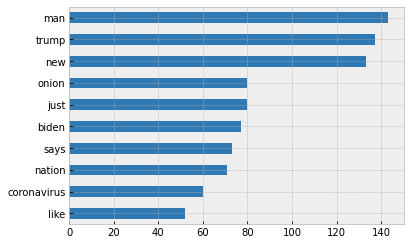

In [19]:
onion_counts = pd.DataFrame(count_vect.fit_transform(onion['title']).toarray(),
                  columns=count_vect.get_feature_names())
onion_counts.sum().sort_values(ascending=True).tail(10).plot(kind='barh')
onion_counts = onion_counts.sum().sort_values(ascending=False).to_frame(name='Observations')
print(onion_counts.head(10))
print(onion_counts.tail(10))

Frequently appearing words include: man, trump, new, onion, just, biden. With the exception of the US presidents, these seem to be fairly neutral.

         Observations
covid             192
police            140
says              118
new               101
19                 96
vaccine            88
man                81
say                74
woman              74
china              66
              Observations
inflammation             1
influence                1
influenced               1
influx                   1
info                     1
inhumane                 1
injected                 1
injecting                1
injections               1
یا                       1


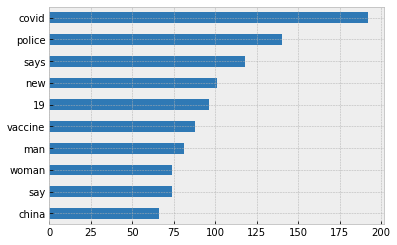

In [20]:
news_counts = pd.DataFrame(count_vect.fit_transform(news['title']).toarray(),
                  columns=count_vect.get_feature_names())
news_counts.sum().sort_values(ascending=True).tail(10).plot(kind='barh')
news_counts = news_counts.sum().sort_values(ascending=False).to_frame(name='Observations')
print(news_counts.head(10))
print(news_counts.tail(10))

Frequently appearing words include: covid, police, new, 19 (presummably as a part of covid 19) and says. Words seem to be more serious compared to those that appeared in the Onion. There seems to be non-English words present in the title. This will be removed before data modeling.

                          Observations
presents topical                    28
onion presents topical              28
onion presents                      28
topical episode                     23
year old                            22
white house                         21
study finds                         20
presents topical episode            19
topical ep                          18
covid 19                            14
                            Observations
finds way reverse                      1
finds way                              1
finds universal mask                   1
finds universal                        1
finds unidentifiable beige             1
finds unidentifiable                   1
finds tutorial levels                  1
finds tutorial                         1
finds trump democrats                  1
zuckerberg vows employees              1


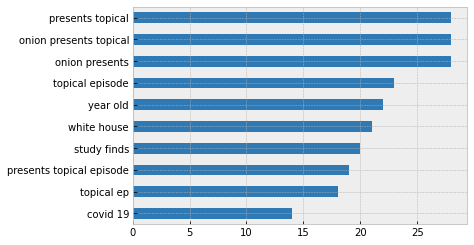

In [21]:
onion_counts_2_3 = pd.DataFrame(count_vect_2_3.fit_transform(onion['title']).toarray(),
                  columns=count_vect_2_3.get_feature_names())
onion_counts_2_3.sum().sort_values(ascending=True).tail(10).plot(kind='barh')
onion_counts_2_3 = onion_counts_2_3.sum().sort_values(ascending=False).to_frame(name='Observations')
print(onion_counts_2_3.head(10))
print(onion_counts_2_3.tail(10))

Highest appearing phrases of 'presents topical', 'onion presents topical', 'onion presents', 'topical episode' seem to be different parts of similar posts. 2 or 3 N-gram vectorized text might not be as useful for our text analysis.

                  Observations
covid 19                    94
year old                    39
19 vaccine                  30
covid 19 vaccine            30
police say                  25
brian laundrie              23
vaccine mandate             21
covid vaccine               18
david amess                 16
alec baldwin                16
                               Observations
file lawsuit whitmer                      1
file lawsuit handcuffed                   1
figure infamous jinx                      1
figure infamous                           1
fights hair                               1
fights confidentiality pledge             1
fights confidentiality                    1
fighting student classroom                1
fighting student                          1
یا نیست                                   1


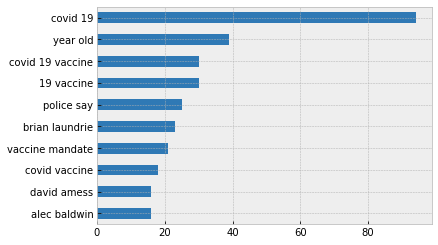

In [22]:
news_counts_2_3 = pd.DataFrame(count_vect_2_3.fit_transform(news['title']).toarray(),
                  columns=count_vect_2_3.get_feature_names())
news_counts_2_3.sum().sort_values(ascending=True).tail(10).plot(kind='barh')
news_counts_2_3 = news_counts_2_3.sum().sort_values(ascending=False).to_frame(name='Observations')
print(news_counts_2_3.head(10))
print(news_counts_2_3.tail(10))

Highest appearing phrases of 'covid 19', 'covid 19 vaccine', '19 vaccine' seem to be all related to covid-19. 'year old', 'police say' do not particularly stand out either. 2 or 3 N-gram vectorized text might not be as useful for our text analysis.

## tf-idf Vectorizer

In [23]:
#creating instances of tfidf Vectorizers
tfidf_vect = TfidfVectorizer(stop_words='english')
tfidf_vect_2_3 = TfidfVectorizer(stop_words='english', ngram_range=(2, 3))

             Weighted Score
man               26.868109
trump             25.586156
new               24.052816
onion             20.842825
biden             17.187871
nation            16.783815
just              16.765288
says              14.732789
coronavirus       14.633079
like              11.958686
            Weighted Score
land              0.216452
column            0.175372
inspired          0.175372
smell             0.175372
hypothesis        0.175372
began             0.175372
staple            0.175372
web               0.175372
2009              0.175372
nostrils          0.175372


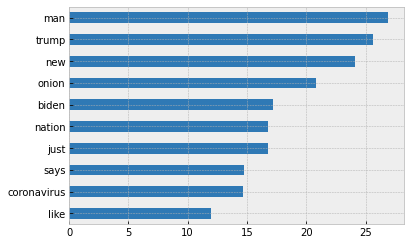

In [24]:
onion_rfidfcounts = pd.DataFrame(tfidf_vect.fit_transform(onion['title']).toarray(),
                  columns=tfidf_vect.get_feature_names())
onion_rfidfcounts.sum().sort_values(ascending=True).tail(10).plot(kind='barh')
onion_rfidfcounts = onion_rfidfcounts.sum().sort_values(ascending=False).to_frame(name='Weighted Score')
print(onion_rfidfcounts.head(10))
print(onion_rfidfcounts.tail(10))

Highest weighing words include: man, trump, new, onion, biden and nation. With the exception of the US presidents, these seem to be fairly neutral.

         Weighted Score
covid         35.354119
police        27.754197
says          24.171370
new           20.770052
19            20.769699
vaccine       19.909792
woman         17.984596
man           17.888011
say           16.996600
china         16.619302
             Weighted Score
retrofit           0.194513
portability        0.194513
remained           0.182077
limited            0.182077
sidelined          0.182077
reduced            0.182077
wreak              0.180600
committing         0.180600
harvesting         0.180600
havoc              0.180600


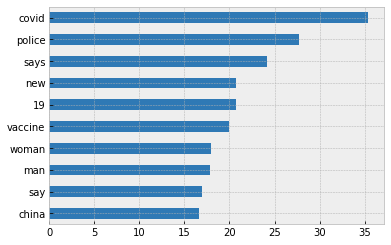

In [26]:
news_tfidfcounts = pd.DataFrame(tfidf_vect.fit_transform(news['title']).toarray(),
                  columns=tfidf_vect.get_feature_names())
news_tfidfcounts.sum().sort_values(ascending=True).tail(10).plot(kind='barh');
news_tfidfcounts = news_tfidfcounts.sum().sort_values(ascending=False).to_frame(name='Weighted Score')
print(news_tfidfcounts.head(10))
print(news_tfidfcounts.tail(10))

Covid, police, says, new, 19 and vaccine take the top weighted spots. These are fairly similar to those count vectorized words and seem to be more serious compared to those that appeared in the Onion

                          Weighted Score
presents topical                4.844263
onion presents topical          4.844263
onion presents                  4.844263
topical episode                 4.302674
year old                        4.040439
study finds                     3.884725
white house                     3.776664
presents topical episode        3.677042
things know                     3.337990
topical ep                      3.026690
                         Weighted Score
diamond began 2009              0.13774
diamond began                   0.13774
2009 web                        0.13774
hypothesis jim anchower         0.13774
began 2009                      0.13774
began 2009 web                  0.13774
2009 web says                   0.13774
nostrils long live              0.13774
2011 diamond                    0.13774
writers smell                   0.13774


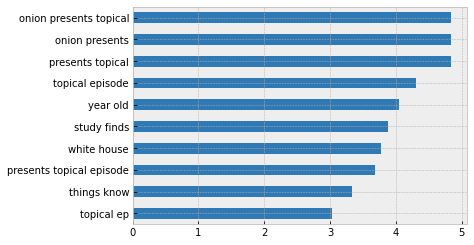

In [25]:
onion_rfidfcounts_2_3 = pd.DataFrame(tfidf_vect_2_3.fit_transform(onion['title']).toarray(),
                  columns=tfidf_vect_2_3.get_feature_names())
onion_rfidfcounts_2_3.sum().sort_values(ascending=True).tail(10).plot(kind='barh')
onion_rfidfcounts_2_3 = onion_rfidfcounts_2_3.sum().sort_values(ascending=False).to_frame(name='Weighted Score')
print(onion_rfidfcounts_2_3.head(10))
print(onion_rfidfcounts_2_3.tail(10))

Similarly to the count vectorized form, highest appearing phrases of 'presents topical', 'onion presents topical', 'onion presents', 'topical episode' seem to be different parts of similar posts.

                  Weighted Score
covid 19               12.750365
year old                6.141195
covid 19 vaccine        5.197790
19 vaccine              5.197790
brian laundrie          4.727121
police say              4.628101
vaccine mandate         3.742815
covid vaccine           3.524365
david amess             3.428242
gabby petito            3.151822
                               Weighted Score
veterinary security                  0.133177
market technology                    0.133177
market technology flat               0.133177
veterinary security fpd              0.133177
cr detector application              0.133177
cr detector                          0.133177
platform digital                     0.133177
platform digital retrofit            0.133177
medical orthopedic industrial        0.133177
direct portability fix               0.133177


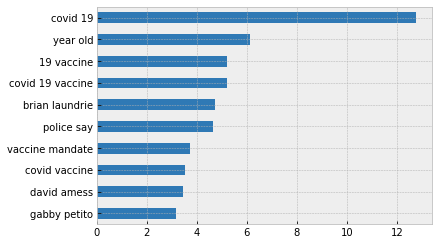

In [27]:
news_tfidfcounts_2_3 = pd.DataFrame(tfidf_vect_2_3.fit_transform(news['title']).toarray(),
                  columns=tfidf_vect_2_3.get_feature_names())
news_tfidfcounts_2_3.sum().sort_values(ascending=True).tail(10).plot(kind='barh')
news_tfidfcounts_2_3 = news_tfidfcounts_2_3.sum().sort_values(ascending=False).to_frame(name='Weighted Score')
print(news_tfidfcounts_2_3.head(10))
print(news_tfidfcounts_2_3.tail(10))

Covid 19 and the vaccine variants of it are all very heavily weighted and appears several times in the top 10 list.

Words from r/News seem to be quite centered about covid-19 and feels more serious, while words from r/TheOnion tends to be more random and neutral. N-gram does not seem to be very useful since length of posts are not very long to begin with and are mostly just permutations of the same sentence/phrase.

# Word Cloud

In [28]:
#preparing data for use for generating word clouds

#onion with count vectorizer
wc_onion_counts = pd.DataFrame(count_vect.fit_transform(onion['title']).toarray(),
                  columns=count_vect.get_feature_names())
wc_onion_counts = wc_onion_counts.sum().sort_values(ascending=False)

#onion with tfidf vectorizer
wc_onion_tfidfcounts = pd.DataFrame(tfidf_vect.fit_transform(onion['title']).toarray(),
                  columns=tfidf_vect.get_feature_names())
wc_onion_tfidfcounts = wc_onion_tfidfcounts.sum().sort_values(ascending=False)

#news with count vectorizer
wc_news_counts = pd.DataFrame(count_vect.fit_transform(news['title']).toarray(),
                  columns=count_vect.get_feature_names())
wc_news_counts = wc_news_counts.sum().sort_values(ascending=False)

#news with tfidf vectorizer
wc_news_tfidfcounts = pd.DataFrame(tfidf_vect.fit_transform(news['title']).toarray(),
                  columns=tfidf_vect.get_feature_names())
wc_news_tfidfcounts = wc_news_tfidfcounts.sum().sort_values(ascending=False)

In [29]:
from matplotlib.colors import LinearSegmentedColormap

#color scheme for count vetorizer word clouds
colors = ["#000000", "#111111", "#101010", "#121212", "#212121", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

#parameters for word clouds
onion_count_wc = WordCloud(width = 1200, height = 900, background_color ='white',
                  colormap=cmap).generate_from_frequencies(wc_onion_tfidfcounts) 

news_count_wc = WordCloud(width = 1200, height = 900, background_color ='white',
                  colormap=cmap).generate_from_frequencies(wc_news_tfidfcounts) 

In [30]:
#color scheme for tfidf vetorizer word clouds
colors2 = ["#ffffff", "#fdfdfd", "#fdfdff", "#fdffff", "#fefefe", "#fefeff"]
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors2)

#parameters for word clouds
onion_tfidf_wc = WordCloud(width = 1200, height = 900, background_color ='black',
                  colormap=cmap2).generate_from_frequencies(wc_onion_tfidfcounts) 

news_tfidf_wc = WordCloud(width = 1200, height = 900, background_color ='black',
                  colormap=cmap2).generate_from_frequencies(wc_news_tfidfcounts) 

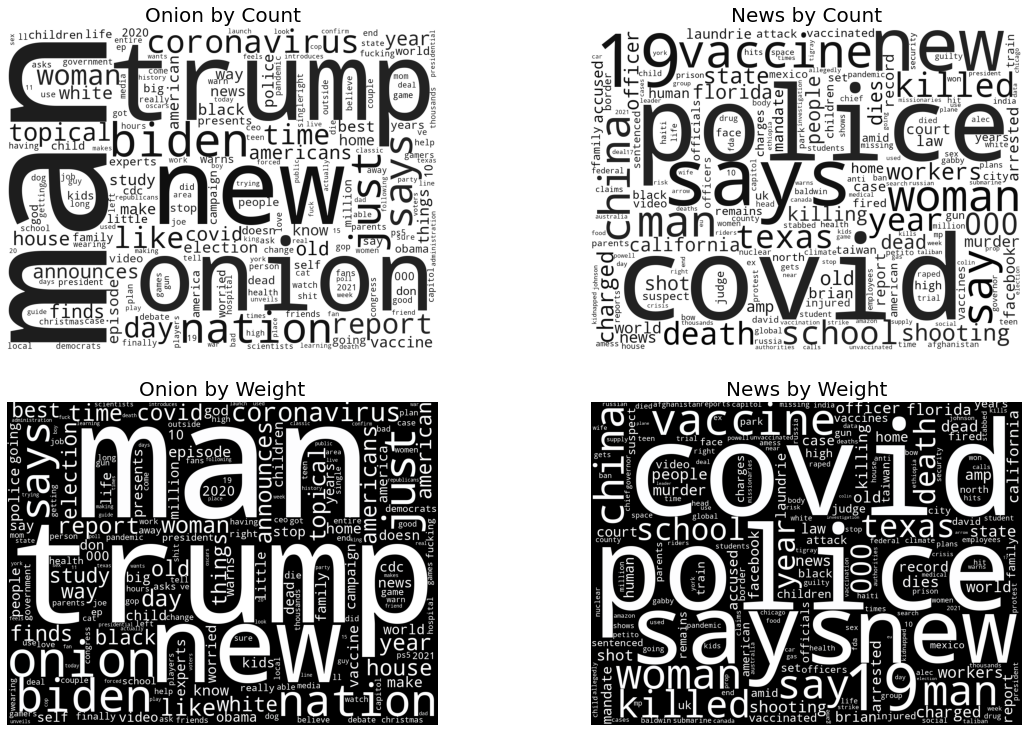

In [31]:
#generating word clouds
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 10))
ax[0,0].imshow(onion_count_wc)
ax[0,1].imshow(news_count_wc)
ax[1,0].imshow(onion_tfidf_wc)
ax[1,1].imshow(news_tfidf_wc)

ax[0,0].set_title('Onion by Count',size=20)
ax[0,1].set_title('News by Count',size=20)
ax[1,0].set_title('Onion by Weight',size=20)
ax[1,1].set_title('News by Weight',size=20)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

plt.tight_layout(h_pad = 3.0,pad=0.1)

1 N-gram was chosen as the base for generating these word clouds as 2-3 N-gran seemed to have multiple repeats of the same word, possibly due to Covid and Covid 19 appearing as phrases. These issues will be sorted out after further processing and lemmatizing of the words.

Some observations:
1. As mentioned earlier in the text data exploration with count vectorizing, posts from r/TheOnion seemed to be more neutral than that of the News. With words like Man, Trump, Biden, Onion and Nation appearing to stand out more.
2. Conversely, words from r/News tend to feel more grim and serious, with words like Police, Killed, Death, Dead, Killed appearing visibily in the word cloud.

# Exporting of data

As there was still some further cleaning of the data such as deleting irrelevant rows from length analysis, datasets will be re-exported. 

In [33]:
#exporting cleaned collected data
onion.to_csv('theonion_cleaned', index=False)
news.to_csv('news_cleaned', index=False)